In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import re
from scipy.sparse import csr_matrix

print(pd.__version__)

0.24.2


In [2]:
# One-hot on abilities
def expand_abilities(df):
    clean_abil = df['abilities'].apply(lambda x: re.findall('(?<=\')[^,].+?(?=\')', x))
    abilities = np.hstack(clean_abil.values)
    uniq_ab = np.unique(abilities)
    array = np.array(clean_abil)

    indptr = [0]
    indices = []
    data = []
    vocab = {}

    for pkmn in array:
        for ab in pkmn:
            index = vocab.setdefault(ab, len(vocab))
            indices.append(index)
            data.append(1)
        indptr.append(len(indices))
    one_hot = csr_matrix((data, indices, indptr), dtype=int).toarray()
    
    df_no_abi = df.drop('abilities', 1)
    inv_vocab = {v: k for k, v in vocab.items()}
    ordered_abi = [inv_vocab[x] for x in range(len(vocab.keys()))]
    df2 = pd.DataFrame()
    df2[ordered_abi] = pd.DataFrame(one_hot)
    return df2

# Combine dataframes
def append_df(df1, df2):
    for col in df1:
        df2[col] = df1[col]
    return df2

In [3]:
df = pd.read_csv("pokemon_revised.csv", encoding='utf-8')

# Drop extra indentifiers
df = df.drop('japanese_name', 1)
df = df.drop('classfication', 1)
#df = df.drop('pokedex_number', 1)

oha = expand_abilities(df)
df = df.drop('abilities', 1)
df = append_df(oha, df)
#df.head()

In [4]:
# Term-doc the types
def one_hot_types(df):
    primary_type = pd.get_dummies(df['type1'])
    secondary_type = pd.get_dummies(df['type2'])
    both_type = primary_type + secondary_type
    df = df.drop('type1', 1)
    df = df.drop('type2', 1)
    return append_df(both_type, df)

df = one_hot_types(df)
#df.head()

In [5]:
def expand_gen(df):
    gen_num = pd.get_dummies(df['generation'])
    df = df.drop('generation', 1)
    df = append_df(gen_num, df)
    df.rename(columns = {i: "gen_%s" % str(i) for i in range(1,8)}, inplace = True )
    return df
df = expand_gen(df)
#df.head()

In [6]:
def create_weakness(df):
    re_against = re.compile("^against_.+$")
    against_ = [x for x in df.columns.values if re_against.match(x)]
    df['weakness'] = df[against_].sum(axis=1)
    return df

df = create_weakness(df)
#df.head()

In [7]:
def expand_against(df):
    re_against = re.compile("^against_.+$")
    against_ = [x for x in df.columns.values if re_against.match(x)]
    for item in against_:
        effective = pd.get_dummies(df[item])
        effective.rename(columns = {val: "%s_%s" % (item, val) for val in effective.columns}, inplace = True)
        df = df.drop(item, 1)
        df = append_df(effective, df)
    return df
df = expand_against(df)
df.head()

,attack,base_egg_steps,base_happiness,base_total,capture_rate,defense,experience_growth,height_m,hp,is_legendary,...,against_steel_0.25,against_steel_0.5,against_steel_1.0,against_steel_2.0,against_steel_4.0,against_water_0.25,against_water_0.5,against_water_1.0,against_water_2.0,against_water_4.0
0,49,5120,70,318,45,49,1059860,0.7,45,0,...,0,0,1,0,0,0,1,0,0,0
1,62,5120,70,405,45,63,1059860,1.0,60,0,...,0,0,1,0,0,0,1,0,0,0
2,82,5120,70,525,45,83,1059860,2.0,80,0,...,0,0,1,0,0,0,1,0,0,0
3,52,5120,70,309,45,43,1059860,0.6,39,0,...,0,1,0,0,0,0,0,0,1,0
4,64,5120,70,405,45,58,1059860,1.1,58,0,...,0,1,0,0,0,0,0,0,1,0


In [8]:
# Label
poke_names = df['name']
legendary_labels = df['is_legendary']
df.drop('name', 1, inplace=True)
df.drop('is_legendary', 1, inplace=True)

In [9]:
# Impute gender
df['percentage_female'] = 100 - df['percentage_male']
df['percentage_male'].fillna(0, inplace = True)
df['percentage_female'].fillna(0, inplace = True)

In [ ]:
df.columns

# K-means Clustering

Cluster by stats and height/weight

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering

from sklearn.decomposition import PCA
stats = ['pokedex_number', 'hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed', 'base_total', 'height_m', 'weight_kg', 'weakness']
pca = PCA(n_components=3)

X = df[stats]
#kmeans = SpectralClustering(n_clusters=20, affinity='nearest_neighbors', random_state=10).fit(X[stats[1:]])
kmeans = KMeans(n_clusters=15, random_state=5).fit(X[stats[1:]])
pred = kmeans.labels_

pca.fit(X[stats[1:]]) 
X_pca = pca.transform(X[stats[1:]])
X_pca = X_pca - np.mean(X_pca)
X_pca = X_pca / np.max(X_pca)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=X_pca[:,0], ys=X_pca[:,1], zs=X_pca[:,2], c=pred)

for i in range(15):
    print(list(poke_names[X[pred == i]['pokedex_number'].values - 1]))
    print()


In [ ]:
from sklearn.cluster import SpectralClustering

pca = PCA(n_components=3)

X = df[stats]
spec_clust = SpectralClustering(n_clusters=20, affinity='nearest_neighbors', random_state=10).fit(X[stats[1:]])
pred = spec_clust.labels_

pca.fit(X[stats[1:]]) 
X_pca = pca.transform(X[stats[1:]])
X_pca = X_pca - np.mean(X_pca)
X_pca = X_pca / np.max(X_pca)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=X_pca[:,0], ys=X_pca[:,1], zs=X_pca[:,2], c=pred)

for i in range(15):
    print(list(poke_names[X[pred == i]['pokedex_number'].values - 1]))
    print()

In [ ]:
#df['experience_growth'].fillna(df['experience_growth'].mean(), inplace=True)

In [ ]:
from sklearn import random_projection
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components=17)
X_sparse_tsvd = tsvd.fit(both_type).transform(both_type)
X_sparse_tsvd.shape

transformer = random_projection.SparseRandomProjection()
#X_new = transformer.fit_transform(both_type)

# BINARY CLASSIFICATION: 

##### Trying different methods of predicting if a Pokemon is legendary

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [126]:
def print_misclass(X, y_true, y_pred):
    match_names = poke_names[X[:,10]-1].values
    miss = X[:,10][y_true != y_pred]
    
    for i in miss:
        i = int(i)
        if y_true.values[i] == 0:
            print(match_names[i] + " is not a legendary, idiot.")
        else:
            print(match_names[i] + " is a legendary, idiot.")

# Standard SVM

In [ ]:
design_matrix = df.values.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(
    design_matrix, legendary_labels, test_size = 0.15, random_state = 200)

In [ ]:
from sklearn.svm import LinearSVC


X2_train, X_val, y2_train, y_val = train_test_split(
    X_train, y_train, test_size = 0.15, random_state = 0)

max_acc = 0
searched_C = -1
for c in np.logspace(-10, 10, 50):
    clf = LinearSVC(random_state=0, tol=1e-4, C = c)
    clf.fit(X2_train, y2_train)
    pred_val = clf.predict(X_val)
    cm = confusion_matrix(y_val, pred_val)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    val_acc = cm[0][0]+cm[1][1]
    if val_acc > max_acc:
        max_acc=val_acc
        searched_C=c
        plot_confusion_matrix(y_val, pred_val, np.array(['Not Legendary', 'Legendary']), normalize=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    design_matrix, legendary_labels, test_size = 0.15, random_state = 200)
X2_train, X_val, y2_train, y_val = train_test_split(
    X_train, y_train, test_size = 0.15, random_state = 0)

clf = LinearSVC(random_state=0, tol=1e-4, C = searched_C)
clf.fit(X2_train, y2_train)
pred_test = clf.predict(X_test)
plot_confusion_matrix(y_test, pred_test, np.array(['Not Legendary', 'Legendary']), normalize=True)

In [ ]:
"""print("Train: ")
match_names = poke_names[X_train[:,10]-1].values
for i in range(len(match_names)):
    predi = pred_train[i]
    if predi:
        print(match_names[i]+" is a legendary.")
    #else:
        #print(match_names[i]+" is a not legendary.")
    """
        
print("Test: ")
match_names = poke_names[X_test[:,10]-1].values
for i in range(len(match_names)):
    predi = pred_test[i]
    if predi:
        print(match_names[i]+" is a legendary.")
    #else:
        #print(match_names[i]+" is a not legendary.")

In [ ]:
print_misclass(X_test, y_test, pred_test)

## RBF Kernelized SVM

In [ ]:
from sklearn.svm import SVC

design_matrix = df.values.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(
    design_matrix, legendary_labels, test_size = 0.15, random_state = 20)
X_train, X_validate, y_train, y_validate = train_test_split(
    X_train, y_train, test_size = 0.15, random_state = 0)

max_acc = 0
searched_C = -1
for c in np.logspace(-0, 10, 11):
    clf = SVC(C = c, kernel = 'rbf', gamma='auto')
    clf.fit(X_train, y_train)
    
    pred_train = clf.predict(X_train)
    plot_confusion_matrix(y_train, pred_train, np.array(['Not Legendary', 'Legendary']), normalize=True)
    
    pred_validate = clf.predict(X_validate)
    cm = confusion_matrix(y_validate, pred_validate)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    
    validation_acc = cm[0][0]+cm[1][1]
    if validation_acc > max_acc:
        max_acc=validation_acc
        searched_C=c
        plot_confusion_matrix(y_validate, pred_validate, np.array(['Not Legendary', 'Legendary']), normalize=True)

## Logistic Regression

In [ ]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

design_matrix = df.values.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(
    design_matrix, legendary_labels, test_size = 0.4, random_state = 69)

In [ ]:
import time

reg = LogisticRegressionCV(Cs=np.logspace(-10, 10, 41), 
                           fit_intercept=True,
                           dual = False,
                          solver='lbfgs',
                           tol=1e-6,
                          max_iter=1e5)

start = time.time()
reg.fit(X_train, y_train)
end = time.time()
print("Fitting took %s ms" % str(end-start))

In [ ]:
pred_train = reg.predict(X_train)
plot_confusion_matrix(y_train, pred_train, np.array(['Not Legendary', 'Legendary']), normalize=True)

pred_test = reg.predict(X_test)
plot_confusion_matrix(y_test, pred_test, np.array(['Not Legendary', 'Legendary']), normalize=True)

In [ ]:
#print_misclass(X_train, y_train, pred_train)
pred_test = reg.predict(X_train)
#print_misclass(X_test, y_test, pred_test)

match_names = poke_names[X_train[:,10]-1].values
pred_test = reg.predict_proba(X_train)
as_prob = np.around(pred_test, decimals=5)[:,1]
for i in range(len(match_names)):
    print('{:>15}: {:.3%}'.format(match_names[i], as_prob[i]))

## Decision Trees

Confusion matrix, without normalization
[[690   0]
 [  0  74]]
Confusion matrix, without normalization
[[114   0]
 [  0  21]]


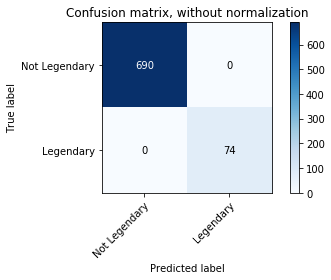

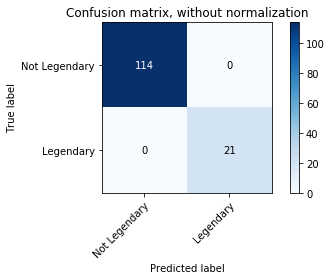

In [133]:
from sklearn import tree
#df_copy = df.drop('base_egg_steps', axis=1)
#df_copy = df_copy.drop('capture_rate', axis=1)
#df_copy = df_copy.drop('pokedex_number', axis=1)
df_copy = df
design_matrix = df_copy.values.astype(np.float32)
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(
    design_matrix, legendary_labels, test_size = 0.15, random_state = 69)

clf = tree.DecisionTreeClassifier(min_samples_split =5)
clf.fit(X_train, y_train)

pred_train = clf.predict(X_train)
plot_confusion_matrix(y_train, pred_train, np.array(['Not Legendary', 'Legendary']), normalize=False)
pred_test = clf.predict(X_test)
plot_confusion_matrix(y_test, pred_test, np.array(['Not Legendary', 'Legendary']), normalize=False)

In [132]:
#print_misclass(X_train, y_train, pred_train)
#X_train[:,10]

Beedrill is not a legendary, idiot.
Weepinbell is not a legendary, idiot.
Diglett is not a legendary, idiot.


In [134]:
print_misclass(X_test, y_test, pred_test)

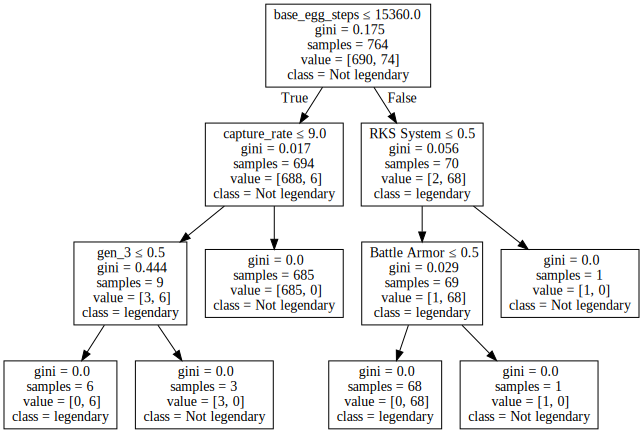

In [135]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names = df_copy.columns,
                               class_names=np.array(['Not legendary', 'legendary']),
                               special_characters=True)

graph = graphviz.Source(dot_data) 
graph

## Random Forest


Normalized confusion matrix
[[1.         0.        ]
 [0.02631579 0.97368421]]
Normalized confusion matrix
[[0.99491094 0.00508906]
 [0.01754386 0.98245614]]


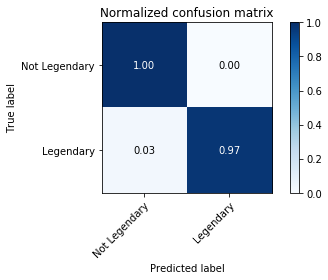

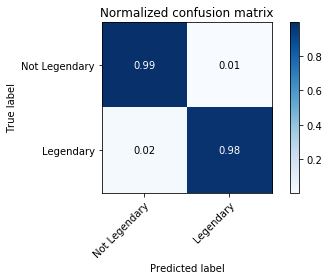

In [136]:
from sklearn.ensemble import RandomForestClassifier
#df_copy = df.drop('base_egg_steps', axis=1)
#df_copy = df_copy.drop('capture_rate', axis=1)
#df_copy = df_copy.drop('pokedex_number', axis=1)
design_matrix = df_copy.values.astype(np.float32)
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(
    design_matrix, legendary_labels, test_size = 0.5, random_state = 69)

clf = RandomForestClassifier(n_estimators=5000, 
                             max_depth=2,
                            max_features=100)

clf.fit(X_train, y_train)

pred_train = clf.predict(X_train)
plot_confusion_matrix(y_train, pred_train, np.array(['Not Legendary', 'Legendary']), normalize=True)
pred_test = clf.predict(X_test)
plot_confusion_matrix(y_test, pred_test, np.array(['Not Legendary', 'Legendary']), normalize=True)

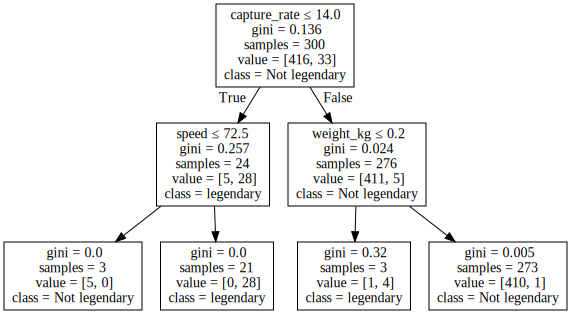

In [142]:
from sklearn.tree import export_graphviz
dot_data = export_graphviz(clf.estimators_[np.random.randint(0,5001)], out_file=None,
                                feature_names = df_copy.columns,
                               class_names=np.array(['Not legendary', 'legendary']),
                               special_characters=True)

graph = graphviz.Source(dot_data) 
graph

5